# ResNet的实现及在cifar10上的应用

## 导入数据集

### 导入包

In [1]:
import mxnet as mx
from mxnet import ndarray as nd
from mxnet import autograd as ag
from mxnet import init
from mxnet import gluon
from mxnet.gluon.data import vision
from mxnet.gluon.data.vision import transforms
from mxnet.gluon import nn
import datetime
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/dyjng/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


### 数据增广

In [2]:
transform_train = transforms.Compose([
#     transforms.CenterCrop(224),
#     transforms.RandomFlipTopBottom(),
#     transforms.RandomColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.0),
#     transforms.RandomLighting(0.0),
#     transforms.Cast('float32'),
    transforms.Resize(224),
    
    # 随机按照 scale 和 ratio 裁剪， 并放缩为 227*227 #(32x32) 的正方形
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0), ratio=(3.0/4.0, 4.0/3.0)),
    transforms.RandomFlipLeftRight(),
    # 将像素值缩小到 (0, 1) 内， 并将数据格式从 “ 高 × 宽 × 通道 ” 改为 “ 通道 × 高 × 宽”
    transforms.ToTensor(),
    # 对图片的每个通道做标准化 --减去均值，除以方差
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),
])
transform_valid = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

### 读取数据集

In [3]:
data_dir = 'data/cifar10/'

batch_size = 64

train_ds = vision.ImageFolderDataset(root=data_dir+'train', flag=1)
valid_ds = vision.ImageFolderDataset(root=data_dir+'valid', flag=1)

train_data = gluon.data.DataLoader(dataset=train_ds.transform_first(transform_train), 
                                   batch_size=batch_size, shuffle=True, last_batch='keep')
valid_data = gluon.data.DataLoader(dataset=valid_ds.transform_first(transform_valid), 
                                   batch_size=batch_size, shuffle=False, last_batch='keep')

In [4]:
print(len(train_ds))
print(len(valid_ds))

print(len(train_data))
for data, label in train_data:
    print(data.shape, label.shape)
    print(label.as_in_context(mx.gpu(0)))
    break

45000
5000
704
(64, 3, 224, 224) (64,)

[1 2 5 5 0 9 3 6 2 5 1 1 5 2 7 9 4 4 9 8 3 3 5 2 5 2 0 8 9 1 0 8 2 7 0 4 4
 0 0 9 8 6 9 1 6 4 3 0 0 3 0 9 5 9 8 8 1 2 9 8 0 0 3 4]
<NDArray 64 @gpu(0)>


## 交叉熵损失函数

In [5]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

## 设计模型 --ResNet

In [6]:
class residual_block(nn.HybridBlock):
    def __init__(self, channels, same_shape=True, first_residual=False, **kwargs):
        super(residual_block, self).__init__(**kwargs)
        self.same_shape = same_shape
        self.first_residual = first_residual
        strides = 1 if same_shape else 2
        with self.name_scope():
            self.bn1 = nn.BatchNorm()
            self.conv1 = nn.Conv2D(channels=channels, kernel_size=1, 
                                   strides=strides, padding=0)
            self.bn2 = nn.BatchNorm()
            self.conv2 = nn.Conv2D(channels=channels, kernel_size=3, 
                                   strides=1, padding=1)
            self.bn3 = nn.BatchNorm()
            self.conv3 = nn.Conv2D(channels=4*channels, kernel_size=1, 
                                   strides=1, padding=0)
            if not same_shape:
                self.conv4 = nn.Conv2D(channels=4*channels, kernel_size=1, 
                                       strides=strides, padding=0)
            elif first_residual:
                self.conv4 = nn.Conv2D(channels=4*channels, kernel_size=1, 
                                       strides=strides, padding=0)
    
    def hybrid_forward(self, F, x):
        x = F.relu(self.bn1(x))
        out = self.conv1(x)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        if not self.same_shape or self.first_residual:
            x = self.conv4(x)
        return out + x

In [7]:
class ResNet50(nn.HybridBlock):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ResNet50, self).__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope():
            net = self.net = nn.HybridSequential()
            # stage 1
#             net.add(nn.BatchNorm())
#             net.add(nn.Activation(activation='relu'))
            net.add(nn.Conv2D(channels=64, kernel_size=7, 
                              strides=2, padding=3))
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.MaxPool2D(pool_size=3, strides=2, padding=1))
            # stage 2
            net.add(residual_block(64, first_residual=True))
            for _ in range(2):
                net.add(residual_block(64))
            # stage 3
            net.add(residual_block(128, same_shape=False))
            for _ in range(3):
                net.add(residual_block(128))
            # stage 4
            net.add(residual_block(256, same_shape=False))
            for _ in range(5):
                net.add(residual_block(256))
            # stage 5
            net.add(residual_block(512, same_shape=False))
            for _ in range(2):
                net.add(residual_block(512))
            # stage 6
            net.add(nn.BatchNorm())
            net.add(nn.Activation(activation='relu'))
            net.add(nn.AvgPool2D(pool_size=7))
            net.add(nn.Flatten())
            net.add(nn.Dense(num_classes))
            
    def hybrid_forward(self, F, x):
        out = x
        for i, f in enumerate(self.net):
            out = f(out)
            if self.verbose:
                print('Block %d, Output: %s' % (i+1, out.shape))
        return out

In [8]:
def get_net(ctx, num_classes=1000):
    net = ResNet50(num_classes=num_classes)
    net.initialize(ctx=ctx, init=init.Xavier())
    return net

In [9]:
net = ResNet50(num_classes=100, verbose=True)
net.initialize()
net

ResNet50(
  (net): HybridSequential(
    (0): Conv2D(None -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
    (2): Activation(relu)
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
    (4): residual_block(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
      (conv1): Conv2D(None -> 64, kernel_size=(1, 1), stride=(1, 1))
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
      (conv2): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
      (conv3): Conv2D(None -> 256, kernel_size=(1, 1), stride=(1, 1))
      (conv4): Conv2D(None -> 256, kernel_size=(1, 1), stride=(1, 1))
   

In [10]:
for data, label in train_data:
    out = net(data)
    break

Block 1, Output: (64, 64, 112, 112)
Block 2, Output: (64, 64, 112, 112)
Block 3, Output: (64, 64, 112, 112)
Block 4, Output: (64, 64, 56, 56)
Block 5, Output: (64, 256, 56, 56)
Block 6, Output: (64, 256, 56, 56)
Block 7, Output: (64, 256, 56, 56)
Block 8, Output: (64, 512, 28, 28)
Block 9, Output: (64, 512, 28, 28)
Block 10, Output: (64, 512, 28, 28)
Block 11, Output: (64, 512, 28, 28)
Block 12, Output: (64, 1024, 14, 14)
Block 13, Output: (64, 1024, 14, 14)
Block 14, Output: (64, 1024, 14, 14)
Block 15, Output: (64, 1024, 14, 14)
Block 16, Output: (64, 1024, 14, 14)
Block 17, Output: (64, 1024, 14, 14)
Block 18, Output: (64, 2048, 7, 7)
Block 19, Output: (64, 2048, 7, 7)
Block 20, Output: (64, 2048, 7, 7)
Block 21, Output: (64, 2048, 7, 7)
Block 22, Output: (64, 2048, 7, 7)
Block 23, Output: (64, 2048, 1, 1)
Block 24, Output: (64, 2048)
Block 25, Output: (64, 100)


In [10]:
# a = True
# b = False
# conv = 0
# if a:
#     conv = 1
# elif b:
#     conv = 2
# if not a or b:
#     print(conv)

In [20]:
def train(net, train_data, valid_data, ctx, num_epoches, optimizer='adam', 
          lr=0.01, lr_decay=0.1, lr_period=50, momentum=0.9, weight_decay=0, 
          cost_peroid=10, print_cost=False):
    if optimizer == 'momentum':
        trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr, 
                                                              'momentum': momentum, 
                                                              'wd': weight_decay})
    elif optimizer == 'adam':
        trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr, 
                                                               'wd': weight_decay})
    
    train_costs = []
    valid_costs = []
    v_loss_train = 0
    n_iter_train = 0
#     v_loss_valid = 0
#     n_iter_valid = 0
    for epoch in range(num_epoches):
        pre_time = datetime.datetime.now()
        train_acc = 0
#         train_loss = 0
        if (epoch+1) % lr_period == 0:
            trainer.set_learning_rate(trainer.learning_rate * lr_decay)
        for data, label in train_data:
            data = data.as_in_context(ctx)
            label = label.astype('float32').as_in_context(ctx)
            with ag.record():
                output = net(data)
                loss = softmax_cross_entropy(output, label)
            loss.backward()
            trainer.step(batch_size)
            train_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
#             train_loss += nd.mean(loss).asscalar()
            cur_loss = nd.mean(loss).asscalar()
            v_loss_train = 0.9 * v_loss_train + 0.1 * cur_loss
            n_iter_train += 1
            corr_loss_train = v_loss_train / (1 - pow(0.9, n_iter_train))
            
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - pre_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = 'Time %02d:%02d:`%02d, ' % (h, m, s)
        
        if valid_data is not None:
            valid_acc = 0
            valid_loss = 0
            for data, label in valid_data:
                data = data.as_in_context(ctx)
                label = label.astype('float32').as_in_context(ctx)
                output = net(data)
                loss = softmax_cross_entropy(output, label)
                valid_acc += nd.mean(output.argmax(axis=1) == label).asscalar()
#                 cur_loss = nd.mean(loss).asscalar()
#                 v_loss_valid = 0.9 * v_loss_valid + 0.1 * cur_loss
#                 n_iter_valid += 1
#                 corr_loss_valid = v_loss_valid / (1 - pow(0.9, n_iter_valid))
                valid_loss += nd.mean(loss).asscalar()
            epoch_str = 'Epoch %d, Train_loss: %s, Train_acc: %s, Valid_acc: %s, ' % (epoch+1, 
                                                                                    corr_loss_train, 
                                                                                    train_acc/len(train_data), 
                                                                                    valid_acc/len(valid_data))
        else:
            epoch_str = 'Epoch %d, Train_loss: %s, Train_acc: %s, ' % (epoch+1, 
                                                                     corr_loss_train, 
                                                                     train_acc/len(train_data))
        if print_cost and (epoch+1) % cost_peroid == 0:
            train_costs.append(corr_loss_train)
#             train_costs.append(train_loss/len(train_data))
            valid_costs.append(valid_loss/len(valid_data))
        
        print(epoch_str + time_str + 'lr: %f' % trainer.learning_rate)
        
    if print_cost:
        x_axis = np.linspace(0, num_epoches, len(train_costs), endpoint=True)
        plt.semilogy(x_axis, train_costs)
        plt.semilogy(x_axis, valid_costs)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()

In [24]:
ctx = mx.gpu(0)
num_epoches = 200
optimizer = 'momentum'
lr = 0.1
lr_decay = 0.1
lr_period = 50
momentum = 0.9
weight_decay = 0
cost_peroid = 10
print_cost = True

In [25]:
net = get_net(ctx, num_classes=10)
net.hybridize()

Epoch 1, Train_loss: 1.85473727769, Train_acc: 0.269775390625, Valid_acc: 0.346716772152, Time 000442, lr: 0.100000
Epoch 2, Train_loss: 1.68658279315, Train_acc: 0.374933416193, Valid_acc: 0.435126582278, Time 000441, lr: 0.100000
Epoch 3, Train_loss: 1.45762767656, Train_acc: 0.4462890625, Valid_acc: 0.549643987342, Time 000440, lr: 0.100000
Epoch 4, Train_loss: 1.36436902208, Train_acc: 0.49609375, Valid_acc: 0.546083860759, Time 000441, lr: 0.100000
Epoch 5, Train_loss: 1.28048147168, Train_acc: 0.541925603693, Valid_acc: 0.627373417722, Time 000441, lr: 0.100000
Epoch 6, Train_loss: 1.20460820828, Train_acc: 0.573153409091, Valid_acc: 0.653678797468, Time 000440, lr: 0.100000
Epoch 7, Train_loss: 1.03211080899, Train_acc: 0.602450284091, Valid_acc: 0.692444620253, Time 000441, lr: 0.100000
Epoch 8, Train_loss: 1.03101385715, Train_acc: 0.632013494318, Valid_acc: 0.704707278481, Time 000440, lr: 0.100000
Epoch 9, Train_loss: 0.913557023832, Train_acc: 0.653631036932, Valid_acc: 0.7

Epoch 71, Train_loss: 0.281671921641, Train_acc: 0.911665482955, Valid_acc: 0.917128164557, Time 000440, lr: 0.010000
Epoch 72, Train_loss: 0.348596345195, Train_acc: 0.913396661932, Valid_acc: 0.919897151899, Time 000441, lr: 0.010000
Epoch 73, Train_loss: 0.248993653139, Train_acc: 0.91435102983, Valid_acc: 0.919699367089, Time 000442, lr: 0.010000
Epoch 74, Train_loss: 0.241796416079, Train_acc: 0.914151278409, Valid_acc: 0.920292721519, Time 000441, lr: 0.010000
Epoch 75, Train_loss: 0.301364435815, Train_acc: 0.915172230114, Valid_acc: 0.92147943038, Time 000441, lr: 0.010000
Epoch 76, Train_loss: 0.220074675054, Train_acc: 0.915793678977, Valid_acc: 0.923061708861, Time 000441, lr: 0.010000
Epoch 77, Train_loss: 0.331847894134, Train_acc: 0.915127840909, Valid_acc: 0.92246835443, Time 000442, lr: 0.010000
Epoch 78, Train_loss: 0.236839132315, Train_acc: 0.915904651989, Valid_acc: 0.925435126582, Time 000440, lr: 0.010000
Epoch 79, Train_loss: 0.303040402469, Train_acc: 0.91703657

Epoch 141, Train_loss: 0.244339126291, Train_acc: 0.930841619318, Valid_acc: 0.922666139241, Time 000442, lr: 0.001000
Epoch 142, Train_loss: 0.226251139696, Train_acc: 0.930109197443, Valid_acc: 0.926819620253, Time 000442, lr: 0.001000
Epoch 143, Train_loss: 0.185013027956, Train_acc: 0.928888494318, Valid_acc: 0.922666139241, Time 000442, lr: 0.001000
Epoch 144, Train_loss: 0.208292516611, Train_acc: 0.930242365057, Valid_acc: 0.92207278481, Time 000442, lr: 0.001000
Epoch 145, Train_loss: 0.210967111365, Train_acc: 0.931285511364, Valid_acc: 0.918512658228, Time 000442, lr: 0.001000
Epoch 146, Train_loss: 0.219909723438, Train_acc: 0.9306640625, Valid_acc: 0.92207278481, Time 000441, lr: 0.001000
Epoch 147, Train_loss: 0.214398938943, Train_acc: 0.929798473011, Valid_acc: 0.923457278481, Time 000442, lr: 0.001000
Epoch 148, Train_loss: 0.172065568173, Train_acc: 0.930220170455, Valid_acc: 0.92227056962, Time 000441, lr: 0.001000
Epoch 149, Train_loss: 0.207014312846, Train_acc: 0.9

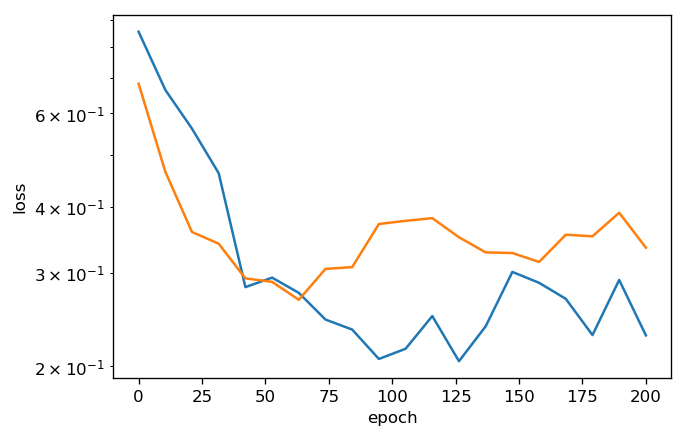

In [26]:
train(net, train_data, valid_data, ctx, num_epoches, optimizer, 
      lr, lr_decay, lr_period, momentum, weight_decay, 
      cost_peroid, print_cost)

In [ ]:
# str = ''
# # str = str + 'a' + '' + 'b'
# print(len(str))

In [ ]:
# for i in range(0):
#     print(i)